## Collatz beta notebook

In [15]:
"""
This notebook analyses the betas of collatz sequences and their relationship
to other components.
"""

# Fix possible import problems
import sys
sys.path.append("..")

# Imports
from math import log2
from fractions import Fraction
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd
from collatz import commons as com
from collatz import generator as gen


# Configuration
k = 3
max_value = 101
max_iterations = 30
start_value = rnd.randint(1, max_value)

if start_value % 2 == 0:
    start_value = start_value + 1

# start_value = 1

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.expand_frame_repr', False)

# Generate Collatz sequence
analysis_frame = gen.generate_odd_collatz_sequence(
    start_value=start_value, k=k, max_iterations=max_iterations)

# Drop last row
analysis_frame = analysis_frame[:-1]

# Derive additional fields
analysis_frame["n"] = analysis_frame.index + 1
analysis_frame.insert(1, "v_1", [start_value] * len(analysis_frame))

# Calculate alpha
analysis_frame["alpha_i"] = analysis_frame["next_collatz"].apply(com.trailing_zeros)
analysis_frame["alpha_i"] = analysis_frame["alpha_i"].astype("int64")
analysis_frame["alpha"] = analysis_frame["alpha_i"].cumsum()
analysis_frame["alpha_max"] = analysis_frame["n"] * log2(k) + log2(start_value)
analysis_frame["alpha_max"] = analysis_frame["alpha_max"].astype('int64') + 1

# Calculate beta
analysis_frame["beta_i"] = 1 + 1/(k*analysis_frame["collatz"])
analysis_frame["beta"] = analysis_frame["beta_i"].cumprod()
analysis_frame["beta_log"] = analysis_frame["beta"].apply(log2)
analysis_frame["beta_log_max"] = analysis_frame["alpha_max"] - \
                             analysis_frame["n"] * log2(k) - log2(start_value)

analysis_frame["beta_log_cycle"] = (analysis_frame["n"] * log2(k)).astype('int64') + 1 - \
                                   analysis_frame["n"] * log2(k)

analysis_frame["beta_max"] = 2**analysis_frame["beta_log_max"]
analysis_frame["beta_cycle"] = 2**analysis_frame["beta_log_cycle"]

analysis_frame["beta_frac"] = analysis_frame["beta"].apply(
    Fraction.from_float).apply(Fraction.limit_denominator)

analysis_frame["beta_max_frac"] = analysis_frame["beta_max"].apply(
    Fraction.from_float).apply(Fraction.limit_denominator)

analysis_frame["beta_cycle_frac"] = analysis_frame["beta_cycle"].apply(
    Fraction.from_float).apply(Fraction.limit_denominator)

# Print results
print_frame = analysis_frame[[
    "n", "collatz","next_odd",
    "beta", "beta_max", 
    "alpha", "alpha_max", "beta_cycle"
    # "beta_frac", "beta_max_frac", "beta_cycle_frac"
]]

print_frame.columns = ["n","v_i", "v_i+",
                       "b", "b_max", 
                       "a", "a_max", "b_cycle"
                       #"b_frac", "b_max_frac", "b_cycle_frac"
]

final_beta = analysis_frame["beta"][len(analysis_frame)-1]

print("Start value:", start_value, " K:", k, 
      " Final beta:", final_beta, 
      "\n")

print(print_frame.to_string(index=False), "\n")

Start value: 63  K: 3  Final beta: 1.043299797509193 

  n   v_i  v_i+         b     b_max   a  a_max   b_cycle
  1    63    95  1.005291  1.354497   1      8  1.333333
  2    95   143  1.008818  1.805996   2     10  1.777778
  3   143   215  1.011170  1.203998   3     11  1.185185
  4   215   323  1.012738  1.605330   4     13  1.580247
  5   323   485  1.013783  1.070220   5     14  1.053498
  6   485    91  1.014480  1.426960   9     16  1.404664
  7    91   137  1.018196  1.902614  10     18  1.872885
  8   137   103  1.020673  1.268409  12     19  1.248590
  9   103   155  1.023976  1.691212  13     21  1.664787
 10   155   233  1.026178  1.127475  14     22  1.109858
 11   233   175  1.027646  1.503300  16     24  1.479811
 12   175   263  1.029604  1.002200  17     25  1.973081
 13   263   395  1.030909  1.336266  18     27  1.315387
 14   395   593  1.031779  1.781688  19     29  1.753850
 15   593   445  1.032359  1.187792  21     30  1.169233
 16   445   167  1.033132  1.5837

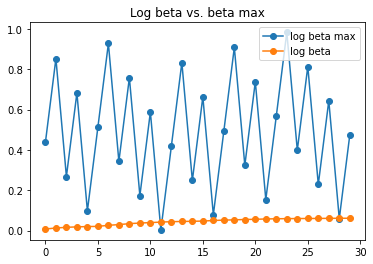

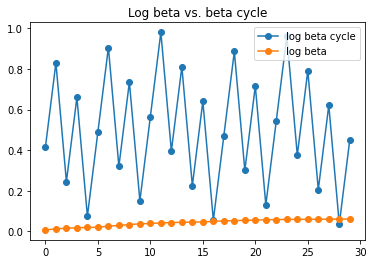

In [16]:
# Plot results
plt.figure()
plt.title("Log beta vs. beta max")
plt.plot(analysis_frame["beta_log_max"], "-o", label="log beta max")
plt.plot(analysis_frame["beta_log"], "-o", label='log beta')
plt.legend()

plt.figure()
plt.title("Log beta vs. beta cycle")
plt.plot(analysis_frame["beta_log_cycle"], "-o", label="log beta cycle")
plt.plot(analysis_frame["beta_log"], "-o", label='log beta')
plt.legend()
plt.show()
